A viable notebook for distinguishing numbers using logistic regression and gradient descent.

First, I'll import all the packages I'll be using:

In [1]:
import pandas as pd #for dataframe control
import matplotlib.pyplot as plt #for plotting
import seaborn as sns #for plotting
%matplotlib inline
import numpy as np #for math
import matplotlib.image as mpimg #for digit image reconstruction

Data comes from Kaggle's digit rec playground challenge. https://www.kaggle.com/c/digit-recognizer

I'll import the training set into a pandas dataframe:

In [2]:
df=pd.read_csv('train.csv')

Before going on, let me visualize this data. Here is the ith number in the data set:

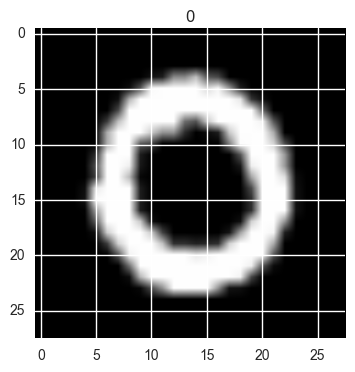

In [3]:
i=1
img=df.iloc[i,1:].as_matrix();
img=img.reshape((28,28));
plt.imshow(img,cmap='gray');
plt.title(df.iloc[i,0]);

The pixels in each image have values that range from 0 to 255. I want to renormalize so that there are only 2 values: 0 and 1. This simplifies the data without losing very much information.

In [4]:
df[df.iloc[:,1:]>0]=1

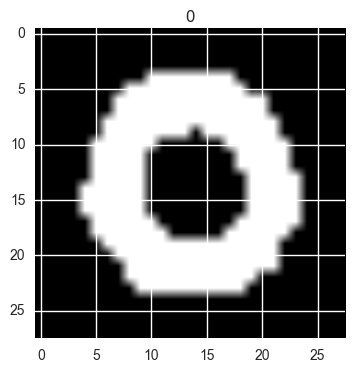

In [5]:
i=1
img=df.iloc[i,1:].as_matrix();
img=img.reshape((28,28));
plt.imshow(img,cmap='gray');
plt.title(df.iloc[i,0]);

Before going any farther, let me split the dataframe into 2 sections: a training set and a cross-validation set. This will let me see if the model truly is predictive, or if it's overfitted to the training data.

Here I'll choose the index values of the training set and the cross-validation set using numpy's random.choice (with replace=False).

In [6]:
trainIndex=np.random.choice(df.index.values,int(len(df)*.8),replace=False);
cvIndex=[num for num in df.index.values if num not in trainIndex];

In [7]:
print(len(trainIndex))
print(len(cvIndex))

33600
8400


Now, I'll define all the functions I'll need for logistic regression and gradient descent.

In [15]:
def sigmoid(Theta,X):
    z=np.dot(Theta,X.transpose())
    g=1/(1+np.exp(-z));
    return g
def CostFunction(y,Theta, X):
    J=-1/len(y)*(np.dot(y,np.log(sigmoid(Theta,X)+.005))+
                 np.dot(np.subtract(np.ones(len(y)),[0])-y,np.log(1.005-sigmoid(Theta,X))));
    return J
def GradDescent(y,Theta,X,alpha):
    D=alpha*np.dot(sigmoid(Theta,X)-y,X)
    ThetaNew=Theta-D
    return ThetaNew

To keep the original data pure, I'll start a new dataframe. This isn't necessary. But I'll do it anyway.

This version of gradient descent is one-vs-all. So I'll create a new column next to the 'label' column which will be 'binary'. 1 if the number in 'label' is the number we are trying to find, 0 otherwise.

In [9]:
df2=df.copy()
df2.insert(1,'binary',0)

Finally, I'll add one additional feature to all the pixel values: a constant. This will let me have a Theta parameter that acts like an offset. 

In [10]:
df2.insert(2,'ones',1)

And finally, I can do some gradient descent.

In [51]:
dfCV=pd.DataFrame(index=cvIndex) #dataframe to record each 1-vs-all test. To compare later.
dfCV['label']=df2.loc[cvIndex,'label']
for x in [0,1,2,3,4,5,6,7,8,9]:
    df2['binary']=0;
    df2.loc[df2.loc[:,'label']==x,'binary']=1;
    X=df2.iloc[trainIndex,2:].values;
    Theta=np.random.rand(len(df2.iloc[1,2:]));
    y=df2.iloc[trainIndex,1].values;
    alpha=.0001
    CF=[];
    for i in range(0,10):
        CF.append(CostFunction(y,Theta,X));
        Theta=GradDescent(y,Theta,X,alpha)
    print(x)
    cvX=df2.iloc[cvIndex,2:].values;
    cvy=df2.iloc[cvIndex,1].values;
    print(np.sum((sigmoid(Theta,cvX)>.5)==(cvy==1))/len(cvy)) #check for high percent for CV set in 1-vs-all system.
    dfCV['cv%s'%(x)]=sigmoid(Theta,cvX) #append results to dfCV for future analysis.

0
0.963571428571
1
0.978928571429
2
0.935952380952
3
0.892857142857
4
0.942380952381
5
0.907023809524
6
0.961785714286
7
0.967976190476
8
0.897738095238
9
0.858095238095


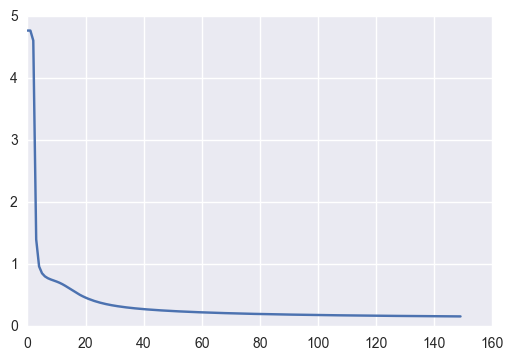

In [58]:
plt.plot(np.arange(0,len(CF)),CF)

Now, currently I have 1-vs-all predictions for every number. This next box of code fines the highest prediction for each sample and uses that to predict the number.

In [59]:
dfCV2=dfCV.copy()
dfCV2.iloc[:,1:]=dfCV2.div(dfCV2.iloc[:,1:].max(axis=1),axis=0)
dfCV2[dfCV2.iloc[:,1:]<1]=0
for x in range(0,10):
    dfCV2.loc[dfCV2.loc[:,'cv%s'%(x)]>0,'cv%s'%(x)]=x;
dfCV2['Predict']=dfCV2.iloc[:,1:].sum(axis=1);
dfCV2[['label','Predict']].head(10)

,label,Predict
3,4,2.0
6,7,7.0
8,5,3.0
18,7,7.0
21,6,6.0
23,0,0.0
28,9,9.0
30,8,8.0
31,9,9.0
35,1,1.0


If I want to look through some of the incorrect answers, I can do that below.

In [63]:
j=0

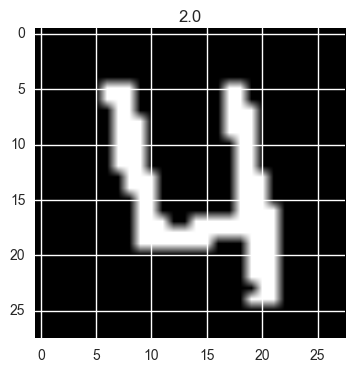

In [64]:
wrongs=dfCV2.loc[dfCV2.loc[:,'label']!=dfCV2.loc[:,'Predict'],['label','Predict']].head(10).index.values;
i=wrongs[j]
img=df.iloc[i,1:].as_matrix();
img=img.reshape((28,28));
plt.imshow(img,cmap='gray');
plt.title(dfCV2.loc[i,'Predict']);
j=j+1

The overall accuracy depends on choices of alpha and how many steps of the gradient descent are preformed. (There should be code to cut off these steps when the stop being useful, but I didn't worry about that today.)

In [66]:
dfCV2=dfCV.copy();
dfCV2.iloc[:,1:]=dfCV2.div(dfCV2.iloc[:,1:].max(axis=1),axis=0);
dfCV2[dfCV2.iloc[:,1:]<1]=0;
for x in range(0,10):
    dfCV2.loc[dfCV2.loc[:,'cv%s'%(x)]>0,'cv%s'%(x)]=x;
dfCV2['Predict']=dfCV2.iloc[:,1:].sum(axis=1);
print(len(dfCV2[dfCV2['label']==dfCV2['Predict']])/len(dfCV2))

0.7410714285714286


Recorded success percents for different parameters:

.758 with num of steps=25, alpha=.0001

.814 with num of steps=100, alpha=.0001

.829 with num of steps=150, alpha=.00005

.858 with num of steps=150, alpha=.00001

.825 with num of steps=150, alpha=.000005

So now I'll apply the same algorithm to the full training set and use the derived Thetas on the test set.

In [53]:
dftest=pd.read_csv('test.csv')
dftest[dftest.iloc[:,1:]>0]=1
dftest.insert(0,'ones',1)
Xtest=dftest.iloc[:,:];
dfTest=pd.DataFrame();
dfTest['ImageId']=dftest.index

In [54]:
dfTest=pd.DataFrame();
dfTest['ImageId']=dftest.index
for x in [0,1,2,3,4,5,6,7,8,9]:
    df2['binary']=0;
    df2.loc[df2.loc[:,'label']==x,'binary']=1;
    X=df2.iloc[:,2:].values;
    Theta=np.random.rand(len(df2.iloc[1,2:]));
    y=df2.iloc[:,1].values;
    alpha=.00001
    CF=[];
    err=0
    for i in range(0,150):
        CF.append(CostFunction(y,Theta,X));
        Theta=GradDescent(y,Theta,X,alpha)
    print(x)
    print(np.sum((sigmoid(Theta,X)>.5)==(y==1))/len(y))
    dfTest['predict%s'%(x)]=sigmoid(Theta,Xtest)

0
0.970476190476
1
0.980976190476
2
0.956880952381
3
0.948071428571
4
0.951523809524
5
0.944976190476
6
0.970214285714
7
0.968714285714
8
0.925714285714
9
0.938047619048


In [55]:
dfTest2=dfTest.copy();
dfTest2.iloc[:,1:]=dfTest2.div(dfTest2.iloc[:,1:].max(axis=1),axis=0);
dfTest2[dfTest2.iloc[:,1:]<1]=0;
for x in range(0,10):
    dfTest2.loc[dfTest2.loc[:,'predict%s'%(x)]>0,'predict%s'%(x)]=x;
dfTest2['Predict']=dfTest2.iloc[:,1:].sum(axis=1);
dfTest2['Label']=dfTest2['Predict'];
dfSubmit=dfTest2[['ImageId','Label']].copy();
dfSubmit['ImageId']=dfSubmit['ImageId']+1;

In [56]:
dfSubmit.head(10)

,ImageId,Label
0,1,2.0
1,2,0.0
2,3,9.0
3,4,9.0
4,5,2.0
5,6,7.0
6,7,0.0
7,8,3.0
8,9,0.0
9,10,3.0


In [57]:
#dfSubmit.to_csv('LR_GD_170130.csv',index=False)

## 86% precision rate.